In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tnrange, tqdm_notebook
import gc
import operator

In [2]:
from scipy import stats

In [3]:
sns.set_context('talk')

In [4]:
pd.set_option('display.max_columns', 500)

In [5]:
import warnings
warnings.filterwarnings('ignore', message='Changing the shape of non-C contiguous array')

# Read the data

In [6]:
dfXtrain = pd.read_csv('preprocessed_csv/train_tree.csv', index_col='id', sep=';')
dfXtest = pd.read_csv('preprocessed_csv/test_tree.csv', index_col='id', sep=';')
dfYtrain = pd.read_csv('preprocessed_csv/y_train_tree.csv', header=None, names=['ID', 'COTIS'], sep=';')

In [7]:
dfYtrain = dfYtrain.set_index('ID')

# Preprocessing

Заполним пропуски в департаменте

In [8]:
dfXtrain.department = dfXtrain.department.fillna(method='ffill')
dfXtrain.subreg = dfXtrain.subreg.fillna(method='ffill')

Вынесем var14, department и subreg.

In [9]:
dropped_col_names = ['var14', 'department', 'subreg'] 

def drop_cols(df):
    return df.drop(dropped_col_names, axis=1), df[dropped_col_names]

In [10]:
train, dropped_train = drop_cols(dfXtrain)
test, dropped_test = drop_cols(dfXtest)

In [11]:
dropped_train.isnull().sum()

var14         0
department    0
subreg        0
dtype: int64

Добавим инфу о величине города из subreg'a

In [12]:
def add_big_city_cols(df, dropped_df):
    df['big'] = np.where(dropped_df['subreg'] % 100 == 0, 1, 0)
    df['average'] = np.where(dropped_df['subreg'] % 10 == 0, 1, 0)
    df['average'] = df['average'] - df['big']
    df['small'] = 1 - df['big'] - df['average']
    return df

In [13]:
train = add_big_city_cols(train, dropped_train)
test = add_big_city_cols(test, dropped_test)

Декодируем оставшиеся категориальные признаки

In [14]:
categorical = list(train.select_dtypes(exclude=[np.number]).columns)
categorical

['marque', 'energie_veh', 'profession', 'var6', 'var8']

In [15]:
list(test.select_dtypes(exclude=[np.number]).columns)

['marque', 'energie_veh', 'profession', 'var6', 'var8']

In [16]:
for col in categorical:
    print(col, train[col].nunique())

marque 154
energie_veh 5
profession 17
var6 5
var8 23


energie_veh и var6 с помощью get_dummies

In [17]:
small_cat = ['energie_veh', 'var6']

In [18]:
train = pd.get_dummies(train, columns=small_cat)
test = pd.get_dummies(test, columns=small_cat)

Для остальных посчитаем сглаженные средние таргета

In [19]:
big_cat = ['marque', 'profession', 'var8']

Описание для начала

In [20]:
df = pd.concat([dfYtrain.describe()] + [train[col].value_counts().describe() for col in big_cat], axis=1)
df

,COTIS,marque,profession,var8
count,300000.000000,154.000000,17.000000,23.000000
mean,346.063566,1946.168831,17647.058824,13018.000000
std,119.870510,8040.202889,29867.244501,24502.085807
min,94.780000,1.000000,393.000000,1.000000
25%,262.050000,3.000000,2610.000000,775.000000
50%,323.220000,11.500000,5829.000000,2208.000000
75%,407.500000,359.750000,13273.000000,7045.000000
max,1518.810000,73371.000000,110354.000000,91826.000000


Сглаживать будем с 500

Будем использовать среднее, 25%, 50% и 75%

Декодирование

In [21]:
class EncodeWithAggregates():

    def __init__(self, cols, y_train, train, *tests, smooth_coef=None):
        self.cols = cols
        self.y_train = y_train
        self.train = train
        self.tests = tests
        self.Xs = (self.train,) + self.tests
        
        self.miss_val = 'NAN'
        self.percentiles = [25, 50, 75]
        self.names = ['Mean'] + [str(q) for q in self.percentiles]
        self.aggs = [np.mean] + [self.percentile_fix(q) for q in self.percentiles]
        self.miss_val_fills = [agg(y_train) for agg in self.aggs]
        self.train_aggs = [agg(y_train) for agg in self.aggs]
        if smooth_coef:
            self.smooth_coef = smooth_coef
        else:
            self.smooth_coef = {col: 0 for col in cols}
        

    def percentile_fix(self, q):
        def wrapped(a):
            return np.percentile(a, q)

        return wrapped
        
    
    def transform(self):
        for col in self.cols:
            self.encode(col)
            gc.collect()
        return self.Xs
    
    
    def encode(self, col):
        df = pd.concat([self.y_train, self.train[col]], axis=1)
        dfgb = df.groupby(col)
        dfsize = dfgb.size()
        dfsize.ix[self.miss_val] = 0

        for X in self.Xs:                
            agg_size = dfsize.ix[X[col].fillna(self.miss_val)]
            agg_size = pd.DataFrame({'size': agg_size}).set_index(X.index)['size']
            agg_name = "{}_{}".format(col, 'size')
            X[agg_name] = agg_size

        for name, agg, miss_val_fill, train_agg in zip(self.names, self.aggs, self.miss_val_fills, self.train_aggs):
            dfm = dfgb.agg(agg)
            dfm.ix[self.miss_val] = miss_val_fill
            for X in self.Xs:                
                agg_df = dfm.ix[X[col].fillna(self.miss_val)].set_index(X.index)[self.y_train.name]
                agg_size = dfsize.ix[X[col].fillna(self.miss_val)]
                agg_size = pd.DataFrame({'size': agg_size}).set_index(X.index)['size']
                agg_name = "{}_{}".format(col, name)
                X[agg_name] = (agg_df * agg_size + self.smooth_coef[col] * train_agg) / (self.smooth_coef[col] + agg_size)
        
        self.Xs = [X.drop(col, axis=1) for X in self.Xs]

In [22]:
smooth_coef = {'profession': 0, 'var8': 500, 'marque': 500}

train, test = EncodeWithAggregates(big_cat, dfYtrain['COTIS'], train, test, smooth_coef=smooth_coef).transform()

In [23]:
test.shape

(30000, 54)

In [24]:
train.shape

(300000, 54)

In [25]:
train.fillna(-9999, inplace=True)
test.fillna(-9999, inplace=True)

In [26]:
y_train = np.array(dfYtrain)
x_train = np.array(train)
x_test = np.array(test)

# Save routines

In [27]:
dfYtest = pd.DataFrame({'ID': dfXtest.index, 'COTIS': np.zeros(test.shape[0])})
dfYtest = dfYtest[['ID', 'COTIS']]
dfYtest.head()

,ID,COTIS
0,300001,0.0
1,300002,0.0
2,300003,0.0
3,300004,0.0
4,300005,0.0


In [28]:
def save_to_file(y, file_name):
    dfYtest['COTIS'] = y
    dfYtest.to_csv('results/{}'.format(file_name), index=False, sep=';')

In [57]:
model_name = 'with_size_all_divided_another'
dfYtest_stacking = pd.DataFrame({'ID': dfXtrain.index, model_name: np.zeros(train.shape[0])})
dfYtest_stacking = dfYtest_stacking[['ID', model_name]]
dfYtest_stacking.head()

,ID,with_size_all_divided_another
0,1,0.0
1,2,0.0
2,3,0.0
3,4,0.0
4,5,0.0


In [58]:
def save_to_file_stacking(y, file_name):
    dfYtest_stacking[model_name] = y
    dfYtest_stacking.to_csv('stacking/{}'.format(file_name), index=False, sep=';')

# Train XGB

In [31]:
import xgboost as xgb
XGBR = xgb.XGBRegressor
from sklearn.cross_validation import LabelKFold
from sklearn.grid_search import GridSearchCV

In [32]:
def plot_quality(grid_searcher, param_name):
    means = []
    stds = []
    for elem in grid_searcher.grid_scores_:
        means.append(np.mean(elem.cv_validation_scores))
        stds.append(np.sqrt(np.var(elem.cv_validation_scores)))
    means = np.array(means)
    stds = np.array(stds)
    
    params = grid_searcher.param_grid
    
    plt.figure(figsize=(10, 6))
    plt.plot(params[param_name], means)
    plt.fill_between(params[param_name], \
                 means + stds, means - stds, alpha = 0.3, facecolor='blue')
    plt.xlabel(param_name)
    plt.ylabel('MAPE')

In [33]:
def mape(y_true, y_pred): 
    return -np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [34]:
def mape_scorer(est, X, y):
    gc.collect()
    return mape(y, est.predict(X))

In [35]:
class MyGS():
    class Element():
        def __init__(self):
            self.cv_validation_scores = []
        
        
        def add(self, score):
            self.cv_validation_scores.append(score)
    
    
    def __init__(self, param_grid, name, n_folds):
        self.param_grid = {name: param_grid}
        self.grid_scores_ = [MyGS.Element() for item in param_grid]
        
    
    def add(self, score, param_num):
        self.grid_scores_[param_num].add(score)
        

Вот клетка с оптимальными настройками

In [36]:
def grid_search(x_train, y_train, scorer):
    param =   {'base_score':0.5, 'colsample_bylevel':1, 'colsample_bytree':1, 'gamma':0,
               'eta':0.15, 'max_delta_step':0, 'max_depth':9,
               'min_child_weight':1, 'nthread':-1,
               'objective':'reg:linear', 'alpha':0, 'lambda':1,
               'scale_pos_weight':1, 'seed':56, 'silent':True, 'subsample':1}

    diff_num_round_list = [40 for i in range(7)]
    diff_num_round_list[0] = 60
    num_round_list = np.cumsum(diff_num_round_list)
    n_folds = 3

    mygs = MyGS(num_round_list, 'num_round', n_folds=n_folds)

    label_kfold = LabelKFold(np.array(dropped_train['department']), n_folds=n_folds)

    for train_index, test_index in tqdm_notebook(label_kfold, desc='fold'):
        dtrain = xgb.DMatrix(x_train[train_index], 
                             label=y_train[train_index], 
                             missing=-9999,) 
        dvalidation = xgb.DMatrix(x_train[test_index], missing=-9999)
        param['base_score'] = np.mean(y_train[train_index])
        bst = None
        for index, diff_num_round in enumerate(diff_num_round_list):
            bst = xgb.train(param, dtrain, diff_num_round, xgb_model=bst)
            y_pred = bst.predict(dvalidation)
            score = scorer(y_pred, test_index)
            mygs.add(score, index)
        gc.collect()
    
    return mygs

In [37]:
df = pd.DataFrame()
df['crm'] = train['crm']
df['target'] = y_train
df['department'] = dropped_train['department']

In [38]:
gb = df.set_index('department')
gb.loc[1].head()

,crm,target
department,,
1.0,68,254.75
1.0,50,259.89
1.0,95,431.65
1.0,100,577.99
1.0,50,222.67


In [39]:
names = ['slope', 'intercept', 'r_value', 'p_value', 'std_err']
def linreg(df):
    tup = stats.linregress(df.crm, df.target)
    res = dict((k, v) for k, v in zip(names, tup))
    return pd.Series(res)

In [40]:
linreg_coef = df.groupby('department').apply(linreg)[names]

In [41]:
linreg_coef.head()

,slope,intercept,r_value,p_value,std_err
department,,,,,
-1.0,4.191528,126.567500,0.996192,5.557769e-02,0.366858
1.0,3.979562,71.354886,0.707645,0.000000e+00,0.064518
2.0,3.695100,78.862787,0.707187,2.511544e-221,0.096849
3.0,3.364459,95.960800,0.692171,2.611755e-189,0.096522
4.0,3.045565,97.516267,0.663976,4.826496e-164,0.095792


In [42]:
recount_table = pd.concat([df, linreg_coef.loc[df.department].reset_index().drop('department', axis=1).set_index(df.index)], axis=1)

In [43]:
recount_table.head()

,crm,target,department,slope,intercept,r_value,p_value,std_err
id,,,,,,,,
1,68,254.75,1.0,3.979562,71.354886,0.707645,0.0,0.064518
2,50,259.89,1.0,3.979562,71.354886,0.707645,0.0,0.064518
3,95,431.65,1.0,3.979562,71.354886,0.707645,0.0,0.064518
4,100,577.99,1.0,3.979562,71.354886,0.707645,0.0,0.064518
5,50,222.67,1.0,3.979562,71.354886,0.707645,0.0,0.064518


In [44]:
delta = (recount_table.target - recount_table.intercept - recount_table.slope * recount_table.crm) / recount_table.crm
delta.head()

id
1   -1.282575
2   -0.208859
3   -0.186981
4    1.086790
5   -0.953259
dtype: float64

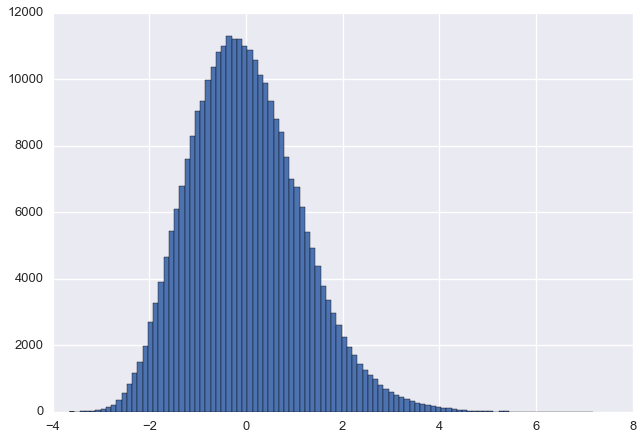

In [45]:
delta.hist(bins=100)

In [46]:
delta = np.array(delta).reshape(y_train.shape)

In [47]:
def scorer(y_pred, test_index):
    table = recount_table.iloc[test_index]
    return mape(y_train[test_index][:, 0], y_pred * table.crm + table.intercept + table.slope * table.crm)

In [48]:
%%time
mygs = grid_search(x_train, delta, scorer)


CPU times: user 23min 54s, sys: 592 ms, total: 23min 55s
Wall time: 23min 55s


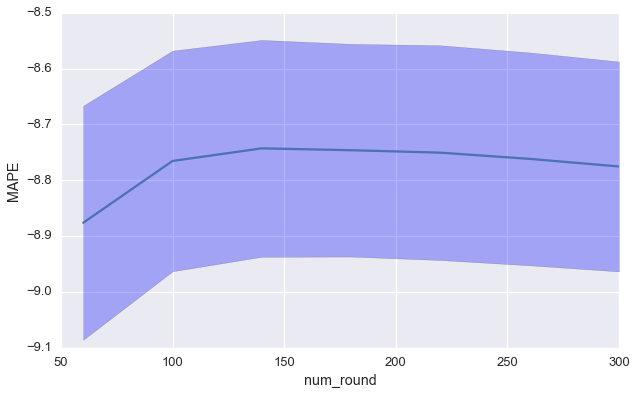

In [49]:
plot_quality(mygs, 'num_round')

In [50]:
def stacking_target(x_train, y_train):
    param =   {'base_score':0.5, 'colsample_bylevel':1, 'colsample_bytree':1, 'gamma':0,
               'eta':0.15, 'max_delta_step':0, 'max_depth':9,
               'min_child_weight':1, 'nthread':-1,
               'objective':'reg:linear', 'alpha':0, 'lambda':1,
               'scale_pos_weight':1, 'seed':56, 'silent':True, 'subsample':1}

    num_round = 140
    n_folds = 5
    
    y_pred = y_train[:, :]

    label_kfold = LabelKFold(np.array(dropped_train['department']), n_folds=n_folds)

    for train_index, test_index in tqdm_notebook(label_kfold, desc='fold'):
        dtrain = xgb.DMatrix(x_train[train_index], 
                             label=y_train[train_index], 
                             missing=-9999,) 
        dvalidation = xgb.DMatrix(x_train[test_index], missing=-9999)
        param['base_score'] = np.mean(y_train[train_index])
        bst = xgb.train(param, dtrain, num_round)
        y_pred[test_index, 0] = bst.predict(dvalidation)
        gc.collect()
    
    return y_pred

In [51]:
%%time
delta_pred = stacking_target(x_train, delta)


CPU times: user 21min 14s, sys: 764 ms, total: 21min 15s
Wall time: 21min 15s


In [59]:
recount_table.reset_index().head()

,id,crm,target,department,slope,intercept,r_value,p_value,std_err
0,1,68,254.75,1.0,3.979562,71.354886,0.707645,0.0,0.064518
1,2,50,259.89,1.0,3.979562,71.354886,0.707645,0.0,0.064518
2,3,95,431.65,1.0,3.979562,71.354886,0.707645,0.0,0.064518
3,4,100,577.99,1.0,3.979562,71.354886,0.707645,0.0,0.064518
4,5,50,222.67,1.0,3.979562,71.354886,0.707645,0.0,0.064518


In [67]:
table = recount_table.reset_index()
onex = delta_pred[:, 0] * table.crm + table.intercept + table.slope * table.crm

In [68]:
onex = np.array(onex).reshape(y_train.shape)

In [69]:
%%time

n_folds = 10
label_kfold = LabelKFold(np.array(dropped_train['department']), n_folds=n_folds)
weight_list = [w for w in np.arange(0.8, 1.2, 0.005)
               ]
scores = [-100 for i in range(n_folds)]
train_scores = [-100 for i in range(n_folds)]
weights = [0 for i in range(n_folds)]

for fold_index, (train_index, test_index) in enumerate(label_kfold):
    X = onex[train_index]
    y = y_train[train_index][:, 0]
    X_validation = onex[test_index]
    y_validation = y_train[test_index][:, 0]
    good_score = -np.Inf
    good_weight = None
    for weight in weight_list:
        y_pred = X[:, 0] * weight
        score = mape(y, y_pred)
        if score > good_score:
            good_score = score
            good_weight = weight
    y_pred = X_validation[:, 0] * good_weight
    scores[fold_index] = mape(y_validation, y_pred)
    train_scores[fold_index] = good_score
    weights[fold_index] = good_weight   

CPU times: user 2.57 s, sys: 0 ns, total: 2.57 s
Wall time: 2.57 s


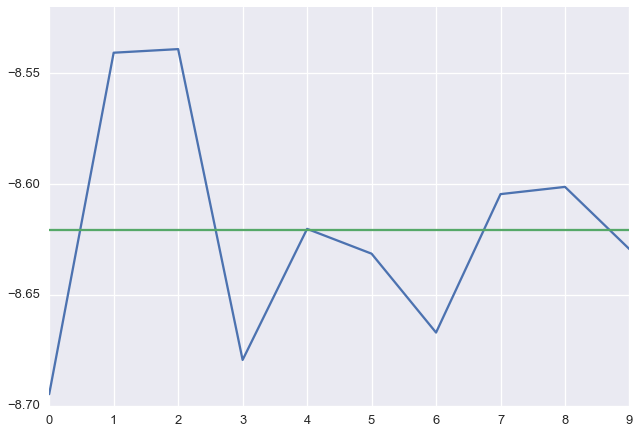

In [70]:
plt.plot(train_scores)
mean = np.mean(train_scores)
plt.plot([mean for i in train_scores])

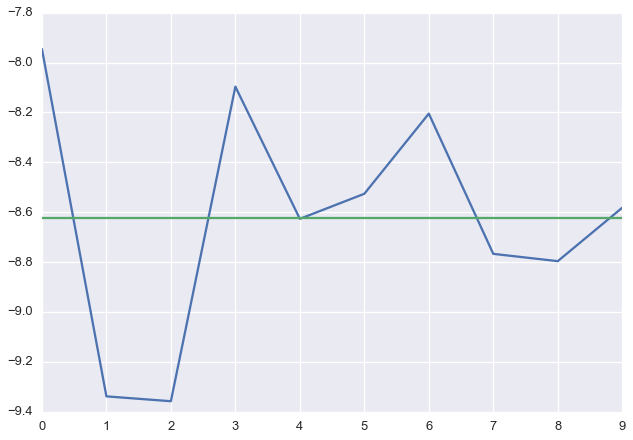

In [71]:
plt.plot(scores)
mean = np.mean(scores)
plt.plot([mean for i in scores])

In [72]:
weights

[0.99000000000000021,
 0.99000000000000021,
 0.99000000000000021,
 0.99000000000000021,
 0.99000000000000021,
 0.99000000000000021,
 0.99000000000000021,
 0.99000000000000021,
 0.99000000000000021,
 0.99500000000000022]

In [73]:
mean

-8.624095496134407

# Save

In [74]:
save_to_file_stacking(onex * 0.99, 'xbg_with_size_divided_another.csv')

In [79]:
def test_target(x_train, y_train, x_test):
    param =   {'base_score':0.5, 'colsample_bylevel':1, 'colsample_bytree':1, 'gamma':0,
               'eta':0.15, 'max_delta_step':0, 'max_depth':9,
               'min_child_weight':1, 'nthread':-1,
               'objective':'reg:linear', 'alpha':0, 'lambda':1,
               'scale_pos_weight':1, 'seed':56, 'silent':True, 'subsample':1}

    num_round = 140
    dtrain = xgb.DMatrix(x_train, 
                         label=y_train, 
                         missing=-9999,) 
    dtest = xgb.DMatrix(x_test, missing=-9999)
    param['base_score'] = np.mean(y_train)
    bst = xgb.train(param, dtrain, num_round)
    y_pred = bst.predict(dtest)
    gc.collect()
    
    return y_pred

In [80]:
%%time
delta_pred = test_target(x_train, delta, x_test)

CPU times: user 5min 36s, sys: 148 ms, total: 5min 36s
Wall time: 5min 36s


In [81]:
linreg_coef.loc[dropped_test.department.unique()]

,slope,intercept,r_value,p_value,std_err
department,,,,,
971,3.456195,75.761862,0.712962,0.0,0.055905
1,3.979562,71.354886,0.707645,0.0,0.064518
974,NaN,NaN,NaN,NaN,NaN


In [82]:
linreg_coef.mean()

slope         3.412184
intercept    96.561713
r_value       0.677539
p_value       0.000573
std_err       0.082011
dtype: float64

In [83]:
mean_row = linreg_coef.mean()
mean_row

slope         3.412184
intercept    96.561713
r_value       0.677539
p_value       0.000573
std_err       0.082011
dtype: float64

In [84]:
linreg_coef.loc[974] = mean_row

In [85]:
test_table = linreg_coef.loc[dropped_test.department].reset_index().set_index(dropped_test.index)

In [86]:
test_table = pd.concat([test_table, test.crm], axis=1)
test_table.head()

,department,slope,intercept,r_value,p_value,std_err,crm
id,,,,,,,
300001,971.0,3.456195,75.761862,0.712962,0.0,0.055905,88
300002,971.0,3.456195,75.761862,0.712962,0.0,0.055905,50
300003,971.0,3.456195,75.761862,0.712962,0.0,0.055905,50
300004,971.0,3.456195,75.761862,0.712962,0.0,0.055905,68
300005,971.0,3.456195,75.761862,0.712962,0.0,0.055905,50


In [87]:
reset_table = test_table.reset_index()
y_pred = delta_pred * reset_table.crm + reset_table.intercept + reset_table.slope * reset_table.crm

In [88]:
save_to_file(y_pred * 0.99, 'xbg_with_size_divided_mean_another.csv')

In [90]:
y_pred = delta_pred * reset_table.crm + mean_row.intercept + mean_row.slope * reset_table.crm

In [91]:
save_to_file(y_pred * 0.99, 'xbg_with_size_divided_mean_another_crazy.csv')